# Reasoning and Descision Making under Uncertainty

## Portfolio Exam 2

### Sensor Fusion - Particle Filter

#### ===================================================================================================================

### Group 17

#### Deekshith Jagadeesh - deekshith.jagadeesh@study.thws.de 
#### Harshith Babu Prakash Babu - harshithbabu.prakashbabu@study.thws.de



#### ===================================================================================================================

### Task P2.1

#### Realize an implementation of the Particle Filter in a programming language of your choice for a simulation of the ball-throwing example from the lecture slides. The task of your Particle Filter is to estimate the positions and velocity vectors of n ≥ 1 balls flying simultaneously only from the observed erroneous positions over time.
 
##### * Simulate the trajectory of n balls with the parameters launch position (x,y) (the imaginary ground is at y = 0), launch speed and launch angle/launch direction of each ball. The inital positions and flying directions of the balls are unknown to your estimation. You can only assume that the ball starts within a rather large range of, for example, 50 × 50 meters.

##### * Simulate the observations of the ball positions (x,y). The estimated ball positions shall be subject to high uncertainty and it shall be possible to parameterize this uncertainty. In addition, the time span between two observations shall be variable and the observations shall be able to drop out completely over a certain period of time. It is necessary that the positions of the ball is also estimated during the time of the sensor failure.

##### * How to deal with more than one ball flying at the same time? How do you define your state? Think intensively about what the transition model and the evaluation model should look like in the case of n balls.How do you estimate n positions from the sensor fusion density? If the density of the ball positions is multimodal, select a suitable method that can determine the positions of the balls.

##### * You are not able to distinguish between the balls. They are indistinguishable from an observational point of view.
  
##### * The starting position and other starting parameters are just as unknown and cannot be specified more precisely. You should handle both the case where the starting positions and directions of the balls are very similar and the case where the positions and directions are clearly different in one common approach.
 
#### Note: There is more than one good approach here. Thus, there is no clear best solution approach in this task.

#### ===================================================================================================================
#### ===================================================================================================================

### Importing Required Libraries

In [1]:
import numpy as np                 # Numerical computing library, used for arrays and math operations
import matplotlib.pyplot as plt    # Plotting library for visualizing data and graphs
from sklearn.cluster import KMeans # Import KMeans clustering algorithm from scikit-learn

### Simulate Ground Truth Trajectories Using Projectile Motion

##### This cell defines a function to compute the position and velocity of a ball over time using classical projectile motion equations under gravity. It then specifies initial launch conditions for multiple balls with varying speeds, angles, and positions. These simulated trajectories represent the ground truth for testing the particle filter.

In [2]:
# Function to simulate projectile motion and compute trajectory + velocity
def simulate_projectile(init_x, init_y, speed, launch_angle, num_points=50):
    g = 9.81  # Acceleration due to gravity (m/s^2)

    # Convert the launch angle from degrees to radians for computation
    angle_rad = np.deg2rad(launch_angle)

    # Total time of flight using projectile motion formula
    flight_time = (2 * speed * np.sin(angle_rad)) / g

    # Generate time steps from 0 to total flight time
    times = np.linspace(0, flight_time, num_points)

    # Compute horizontal position over time
    x_vals = init_x + speed * np.cos(angle_rad) * times

    # Compute vertical position over time using kinematic equation
    y_vals = init_y + speed * np.sin(angle_rad) * times - 0.5 * g * times**2

    # Horizontal velocity remains constant during flight
    vx = speed * np.cos(angle_rad)

    # Vertical velocity decreases linearly due to gravity
    vy = speed * np.sin(angle_rad) - g * times

    # Resultant velocity at each time point using Pythagoras theorem
    velocity = np.sqrt(vx**2 + vy**2)

    # Return positions and velocity arrays
    return x_vals, y_vals, velocity


In [3]:
# Define ranges for random initial conditions based on problem description
x_range = (0, 50)  # X-coordinates from 0 to 50 meters
y_range = (0, 50)  # Y-coordinates from 0 to 50 meters
speed_range = (30.0, 100.0)  # Speed from 30 m/s to 100 m/s
angle_range = (15.0, 85.0)  # Launch angle from 15 to 85 degrees

# --- Start of new/modified code for initial state 'q' ---
# Randomly generate initial position (x, y) and velocity (vx, vy) for a single target state 'q'
# This 'q' is typically used as the true state for a single target that a filter will track.
initial_x = np.random.uniform(x_range[0], x_range[1])
initial_y = np.random.uniform(y_range[0], y_range[1])
initial_speed = np.random.uniform(speed_range[0], speed_range[1])
initial_launch_angle_deg = np.random.uniform(angle_range[0], angle_range[1])

initial_launch_angle_rad = np.deg2rad(initial_launch_angle_deg)
initial_vx = initial_speed * np.cos(initial_launch_angle_rad)
initial_vy = initial_speed * np.sin(initial_launch_angle_rad)

# Define the initial state 'q' as a list [x, y, vx, vy]
q = [initial_x, initial_y, initial_vx, initial_vy]

print(f"Generated Initial State 'q' (for a single target/ground truth):")
print(f"  Initial X position (x): {q[0]:.2f} m")
print(f"  Initial Y position (y): {q[1]:.2f} m")
print(f"  Initial X velocity (vx): {q[2]:.2f} m/s")
print(f"  Initial Y velocity (vy): {q[3]:.2f} m/s")
print(f"\n(Derived from speed: {initial_speed:.2f} m/s, launch angle: {initial_launch_angle_deg:.2f}°)")
# --- End of new/modified code for initial state 'q' ---


# Randomize the number of balls for multiple trajectories between 1 and 4
num_balls = np.random.randint(2, 6)

# Store initial conditions along with their specific noise and dropout parameters
# These parameters will be generated once per ball for consistency
all_ball_params = []
for _ in range(num_balls):
    init_x = np.random.uniform(x_range[0], x_range[1])
    init_y = np.random.uniform(y_range[0], y_range[1])
    speed = np.random.uniform(speed_range[0], speed_range[1])
    launch_angle = np.random.uniform(angle_range[0], angle_range[1])

    # Randomize noise and dropout probability for THIS ball
    ball_noise_std = np.random.uniform(0.5, 5.0)
    ball_dropout_prob = np.random.uniform(0.0, 0.5) # Using 0.0 to 0.5 range as initially discussed

    all_ball_params.append({
        "init_x": init_x,
        "init_y": init_y,
        "speed": speed,
        "launch_angle": launch_angle,
        "noise_std": ball_noise_std,
        "dropout_prob": ball_dropout_prob
    })


Generated Initial State 'q' (for a single target/ground truth):
  Initial X position (x): 46.86 m
  Initial Y position (y): 29.38 m
  Initial X velocity (vx): 27.02 m/s
  Initial Y velocity (vy): 50.95 m/s

(Derived from speed: 57.67 m/s, launch angle: 62.07°)


### Plot Multiple Projectile Trajectories with Distinct Colors and Labels

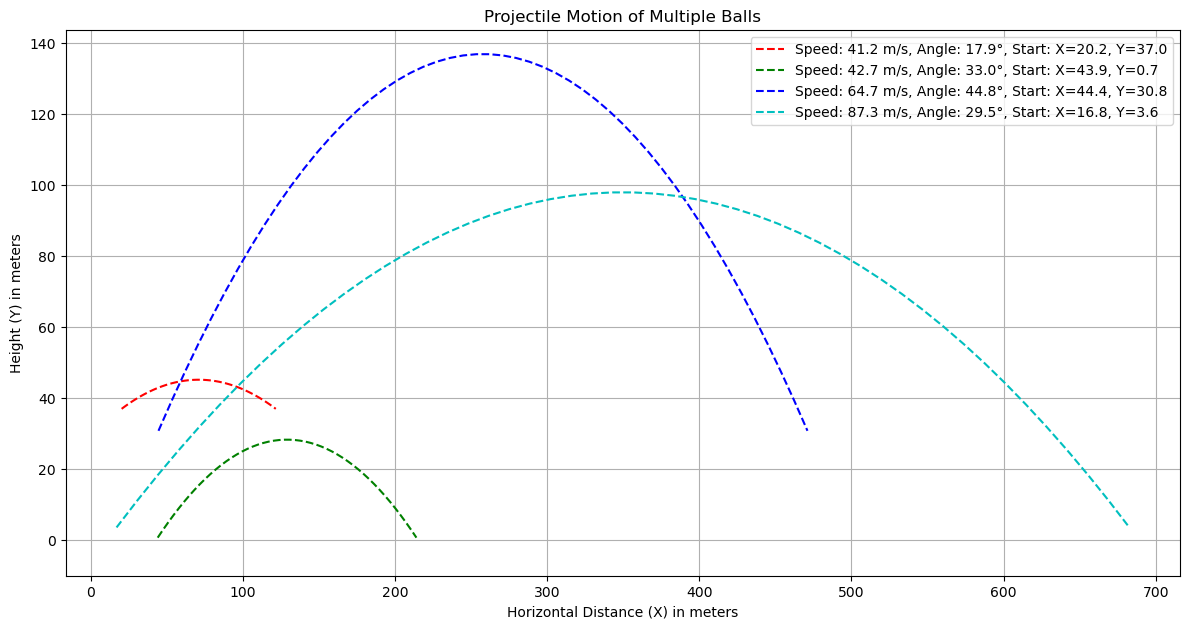

In [4]:

# Define colors for plotting each trajectory distinctly
base_colors = ['r', 'g', 'b', 'c', 'm', 'y', 'k', 'tab:orange', 'tab:purple']
colors = base_colors * (num_balls // len(base_colors) + 1)
colors = colors[:num_balls]

# Create a new figure window with 12x12 inch dimensions
plt.figure(figsize=(12, 12))

# Create the first subplot in a 2-row, 1-column layout (position 1)
plt.subplot(2, 1, 1)
# --- Subplot 1: Projectile Motion of Multiple Balls (True Paths) ---
for ball_params, color in zip(all_ball_params, colors):
    # Extract initial conditions for the projectile simulation
    conditions = {k: ball_params[k] for k in ["init_x", "init_y", "speed", "launch_angle"]}
    x_vals, y_vals, _ = simulate_projectile(**conditions)

    # Create a descriptive label for the true path
    label = (f'Speed: {conditions["speed"]:.1f} m/s, Angle: {conditions["launch_angle"]:.1f}°, '
             f'Start: X={conditions["init_x"]:.1f}, Y={conditions["init_y"]:.1f}')

    # Plot the true trajectory with a dashed line
    plt.plot(x_vals, y_vals, '--' + color, label=label)

# Set title and axis labels for clarity
plt.title('Projectile Motion of Multiple Balls')
plt.xlabel('Horizontal Distance (X) in meters')
plt.ylabel('Height (Y) in meters')

# Display a grid for easier interpretation
plt.grid(True)

# Ensure the bottom of the y-axis starts from -100 (optional based on your dataset)
plt.ylim(bottom=-10)

# Show the legend to distinguish between each projectile's path
plt.legend()

# Adjust spacing to prevent subplot content from overlapping
plt.tight_layout()

# Render the final plot
plt.show()


### Simulate Noisy and Incomplete Observations with Dropout

##### This function generates simulated observations by adding Gaussian noise to given x and y position arrays, modeling measurement inaccuracies. It also introduces random data dropout, representing missing observations, by setting some points to NaN with a specified probability.

In [5]:
# Function to simulate noisy measurements with optional dropout (missing data)
def simulate_noisy_observations(x_vals, y_vals, noise_std=1.0, dropout_prob=0.1):
    # Add Gaussian noise to x and y coordinates
    # noise_std controls the spread of the noise (standard deviation)
    noisy_x = x_vals + np.random.normal(0, noise_std, x_vals.shape)
    noisy_y = y_vals + np.random.normal(0, noise_std, y_vals.shape)
    
    # Simulate dropout: randomly mark some data points as missing (NaN)
    # dropout_mask is True where data is kept, False where it is dropped
    dropout_mask = np.random.rand(len(noisy_x)) > dropout_prob  # Keep values with (1 - dropout_prob) chance
    
    # Apply mask: set values to NaN where dropout occurs
    noisy_x[~dropout_mask] = np.nan
    noisy_y[~dropout_mask] = np.nan
    
    # Return the noisy and possibly incomplete observation arrays
    return noisy_x, noisy_y


### Visualize True Projectile Trajectories Alongside Noisy Observations 

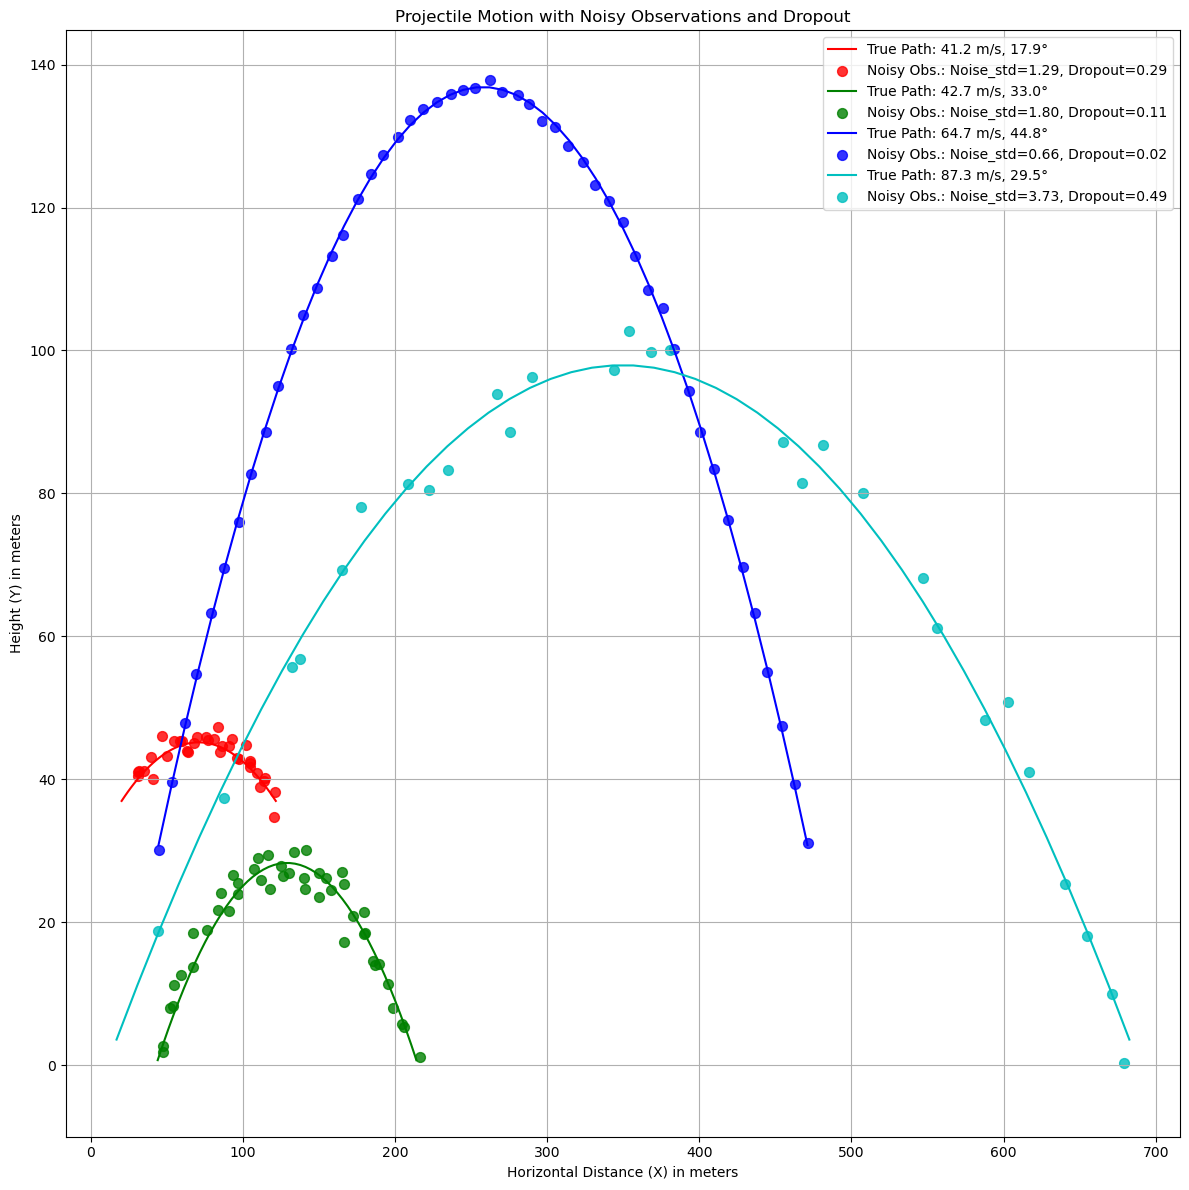

In [6]:
# Create a figure with a 12x12 inch canvas
plt.figure(figsize=(12, 12))

# --- Subplot 2: Projectile Motion with Noisy Observations and Dropout ---
for ball_params, color in zip(all_ball_params, colors):
    # Extract initial conditions for the projectile simulation
    conditions = {k: ball_params[k] for k in ["init_x", "init_y", "speed", "launch_angle"]}
    x_vals, y_vals, _ = simulate_projectile(**conditions) # Get true path

    # Use the pre-determined noise and dropout parameters for this specific ball
    noise_std = ball_params["noise_std"]
    dropout_prob = ball_params["dropout_prob"]

    # Simulate noisy observations using the consistent parameters
    noisy_x, noisy_y = simulate_noisy_observations(
        x_vals, y_vals,
        noise_std=noise_std,
        dropout_prob=dropout_prob
    )

    # Define labels for the true path and noisy observations
    label_real = f'True Path: {conditions["speed"]:.1f} m/s, {conditions["launch_angle"]:.1f}°'
    label_noisy = f'Noisy Obs.: Noise_std={noise_std:.2f}, Dropout={dropout_prob:.2f}'

    # Plot the true trajectory with a solid line for reference
    plt.plot(x_vals, y_vals, '-' + color, label=label_real)

    # Plot the noisy observations as scattered points
    plt.scatter(noisy_x, noisy_y, s=50, color=color, alpha=0.8, label=label_noisy)

# Set the plot title
plt.title('Projectile Motion with Noisy Observations and Dropout')

# Label the X and Y axes
plt.xlabel('Horizontal Distance (X) in meters')
plt.ylabel('Height (Y) in meters')

# Enable gridlines for readability
plt.grid(True)

# Set lower limit of y-axis for visual consistency
plt.ylim(bottom=-10)

# Add a legend to distinguish paths
plt.legend()

# Adjust plot layout to prevent overlap of labels or elements
plt.tight_layout()

# Display the plot
plt.show()


### Particle Filter Implementation for Tracking Projectile Motion

##### This code implements core particle filter functions to estimate the position of a projectile under gravity. It includes: 
##### initialize_projectiles: Generates particles with noisy initial positions and velocities based on speed and angle. 
#####  predict_projectile_motion: Updates particle positions and velocities over time with motion noise and gravity effects.
##### update_particle_weights: Assigns weights to particles based on their distance to noisy measurements using Gaussian likelihood. 
##### resample_particles: Resamples particles proportionally to weights to focus on likely states.
##### estimate_position: Computes weighted average of particle positions as the state estimate.
##### effective_sample_size: Calculates particle diversity to detect degeneracy. 
##### simulate_projectile_measurements: Generates noisy observed positions from true projectile trajectories for testing.

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

# Initialization Function
# This function initializes the particles for the projectile motion simulation.
# Particles are initialized with random Gaussian values around the initial conditions.
# The initial conditions are the mean of the Gaussian and the standard deviation is the noise.
def initialize_projectiles(N, initial_x, initial_y, initial_speed, launch_angle, initial_noise):
    particles = np.empty((N, 4))  # Each particle has [x, y, vx, vy]
    particles[:, 0] = initial_x + np.random.normal(0, initial_noise, size=N)  # x
    particles[:, 1] = initial_y + np.random.normal(0, initial_noise, size=N)  # y
    # Ensure initial y is not negative, even with noise
    particles[:, 1] = np.maximum(0.0, particles[:, 1])

    particles[:, 2] = initial_speed * np.cos(np.deg2rad(launch_angle))  # vx
    particles[:, 3] = initial_speed * np.sin(np.deg2rad(launch_angle))  # vy
    return particles

# Prediction Function
# This function updates the particles' positions and velocities according to the projectile motion model.
# Noise is added to the x and y positions to account for uncertainty in the model.
# CRITICAL: Includes stopping logic for particles when they hit the ground.
def predict_projectile_motion(particles, delta_t, g, x_noise, y_noise, N):
    # Store previous y positions to detect crossing
    y_before_update = particles[:, 1].copy()

    # x(t+1) = x(t) + vx*dt + noise
    particles[:, 0] += particles[:, 2] * delta_t + np.random.normal(0, x_noise, size=N)

    # y(t+1) = y(t) + vy*dt - 0.5*g*dt^2 + noise
    particles[:, 1] += particles[:, 3] * delta_t - 0.5 * g * delta_t**2 + np.random.normal(0, y_noise, size=N)

    # Update velocities: vx remains the same (no air drag), vy affected by gravity
    particles[:, 2] += 0.0 # No change for vx
    particles[:, 3] += -g * delta_t # vy affected by gravity

    # --- Ground Collision Logic for PARTICLES ---
    # Identify particles that have hit or gone below ground level
    # We check if it was above and now at/below ground (on_ground_mask),
    # OR if it's already effectively at 0 and still has velocity (already_on_ground_and_moving)
    # The small epsilon (0.01) helps with floating point precision near zero.
    on_ground_mask = (y_before_update > 0.01) & (particles[:, 1] <= 0.01)
    already_on_ground_and_moving = (particles[:, 1] <= 0.01) & ((particles[:, 2] != 0.0) | (particles[:, 3] != 0.0))

    combined_mask = on_ground_mask | already_on_ground_and_moving

    # For particles that hit the ground or are already on ground and should stop:
    particles[combined_mask, 1] = 0.0 # Clamp y position to exactly 0
    particles[combined_mask, 2] = 0.0 # Set horizontal velocity to 0 (stops rolling)
    particles[combined_mask, 3] = 0.0 # Set vertical velocity to 0 (stops bouncing/falling)

    return particles

# Weight Update Function
# This function updates the weights of each particle based on the difference between the predicted and measured positions.
# The weights indicate how well each particle matches the measurement.
def update_particle_weights(particles, weights, measured_position, noise_std_dev, N):
    # If the measurement itself is None (due to dropout) or below ground, give it a very low weight
    if measured_position is None or measured_position[1] < 0:
        weights.fill(1.e-200) # Effectively zero weight
    else:
        for i in range(N):
            distance = np.linalg.norm(particles[i, :2] - measured_position)  # Euclidean distance
            # Gaussian PDF calculation
            weights[i] = (1 / np.sqrt(2 * np.pi * noise_std_dev**2)) * np.exp(-(distance**2) / (2 * noise_std_dev**2))
    weights += 1.e-200  # Prevent divide-by-zero errors or issues with all zeros
    weights /= np.sum(weights)  # Normalize weights to sum to 1
    return weights

# Resampling Function
# This function resamples the particles based on their weights to keep those that best match the measurements.
# Resampling prevents degeneracy where most particles have negligible weight.
def resample_particles(particles, weights):
    particles_resampled = np.zeros_like(particles)
    N = len(particles)
    cumulative_sum = np.cumsum(weights)
    cumulative_sum[-1] = 1.0  # ensure last value is exactly 1.0 to avoid floating point issues
    indexes = np.searchsorted(cumulative_sum, np.random.random(N))  # sample from cumulative distribution
    particles_resampled[:] = particles[indexes]
    weights.fill(1.0 / N)  # reset weights after resampling
    return particles_resampled

# Estimation Function
# This function computes the mean position of the particles weighted by their weights.
# This acts as the estimated position of the projectile at a given timestep.
def estimate_position(particles, weights):
    pos = particles[:, :2]  # Extract x and y positions
    mean = np.average(pos, weights=weights, axis=0)  # Weighted average
    # Ensure estimated y position is not negative
    mean[1] = np.maximum(0.0, mean[1])
    return mean

# Effective Sample Size Function
# This function calculates the effective sample size to determine when resampling is necessary.
# If the effective number of particles is too small, many have near-zero weights.
def effective_sample_size(weights):
    return 1.0 / np.sum(np.square(weights))

# Simulate measurements of the projectile motion with noise
# CRITICAL: This function calculates the true trajectory step-by-step
# and applies ground stopping to both the true path and noisy observations.
def simulate_projectile_measurements(t_array, initial_x, initial_y, initial_speed, launch_angle, g, noise_std_dev):
    theta_rad = np.radians(launch_angle)

    x_true_trajectory = np.zeros_like(t_array, dtype=float)
    y_true_trajectory = np.zeros_like(t_array, dtype=float)

    current_x = float(initial_x)
    current_y = float(initial_y)
    current_vx = float(initial_speed * np.cos(theta_rad))
    current_vy = float(initial_speed * np.sin(theta_rad))

    has_landed = False # Flag to indicate if the projectile has landed

    for i in range(len(t_array)):
        if has_landed:
            # If already landed, maintain position at ground and zero velocity
            current_y = 0.0
            current_vx = 0.0
            current_vy = 0.0
            # current_x retains its value from the moment of landing
        else:
            # Calculate delta_t for the current step. For the first step (i=0), dt_step will be t_array[0]
            dt_step = t_array[i] - (t_array[i-1] if i > 0 else 0.0)

            # Predict next state (before applying ground logic)
            next_x_pred = current_x + current_vx * dt_step
            next_y_pred = current_y + current_vy * dt_step - 0.5 * g * dt_step**2
            next_vy_pred = current_vy - g * dt_step

            # Check for ground collision in the next step
            if next_y_pred <= 0.01: # Use small epsilon for checking landing
                # Projectile hits or goes below ground in this step
                current_y = 0.0 # Clamp y to 0
                current_vx = 0.0 # CRITICAL: Stop horizontal motion
                current_vy = 0.0 # Stop vertical motion
                has_landed = True # Mark as landed
                current_x = next_x_pred # Keep the x where it hit the ground
            else:
                # Otherwise, update normally
                current_x = next_x_pred
                current_y = next_y_pred
                current_vy = next_vy_pred

        x_true_trajectory[i] = current_x
        y_true_trajectory[i] = current_y

    # Add noise to the physically corrected true trajectory for observations
    noise_x = np.random.normal(scale=noise_std_dev, size=x_true_trajectory.shape)
    noise_y = np.random.normal(scale=noise_std_dev, size=y_true_trajectory.shape)
    x_noisy = x_true_trajectory + noise_x
    y_noisy = y_true_trajectory + noise_y

    # Ensure noisy observations do not go below ground
    y_noisy = np.maximum(0.0, y_noisy)

    return x_true_trajectory, y_true_trajectory, x_noisy, y_noisy


### Initialize Simulation Parameters and Generate Noisy Observations for Dual Projectile Tracking


In [50]:
# --- Main Simulation ---

N = 500  # INCREASED: Number of particles per projectile (e.g., from 100 to 500 or even 1000)
g = 9.81  # Gravitational acceleration
delta_t = 0.1 # Simulation time increment

# Randomize the number of projectiles
# np.random.seed(42) # Optional: for reproducible random results
num_projectiles = np.random.randint(3, 6) # Randomly choose between 1 and 3 projectiles

# Store parameters for each projectile
projectile_params = []
for _ in range(num_projectiles):
    # MODIFIED LINE: Ensure initial_x is always positive
    initial_x = np.random.uniform(0, 2) # Changed from -2 to 0
    initial_y = np.random.uniform(0, 3) # Ensure initial y is non-negative and slightly above ground
    initial_speed = np.random.uniform(10, 30)
    launch_angle = np.random.uniform(30, 70)
    # ADJUSTED NOISE HERE:
    measurement_noise = np.random.uniform(0.5, 2.0) # Reduced upper bound for smoother observed path
    process_noise_x = np.random.uniform(0.01, 0.1)  # REDUCED for smoother estimation
    process_noise_y = np.random.uniform(0.01, 0.1)  # REDUCED for smoother estimation
    initial_noise = np.random.uniform(0.1, 0.5)    # REDUCED for a tighter initial particle spread

    projectile_params.append({
        'initial_x': initial_x,
        'initial_y': initial_y,
        'initial_speed': initial_speed,
        'launch_angle': launch_angle,
        'measurement_noise': measurement_noise,
        'process_noise_x': process_noise_x,
        'process_noise_y': process_noise_y,
        'initial_noise': initial_noise
    })

# Determine the longest flight time among all projectiles to set the simulation duration
max_time_flight = 0.0
for params in projectile_params:
    # Approximate time to reach ground for initial calculation of t array length
    time_flight = (2 * params['initial_speed'] * np.sin(np.deg2rad(params['launch_angle']))) / g
    if time_flight > max_time_flight:
        max_time_flight = time_flight

# Extend time significantly to ensure all trajectories finish and land properly, even with noise
t = np.arange(0.0, max_time_flight * 1.5 + delta_t, delta_t)

# --- MODIFIED DROPOUT PERIOD SETTINGS ---
# To have a more significant dropout period all the time:

# 1. Calculate a fixed start index (e.g., at 20% of the total simulation time)
dropout_start_index = int(0.2 * len(t))

# 2. Calculate a fixed duration (e.g., 50% of the total simulation time)
dropout_duration_steps = int(0.5 * len(t))

# Ensure the dropout period does not exceed the total simulation time
if dropout_start_index + dropout_duration_steps > len(t):
    dropout_duration_steps = len(t) - dropout_start_index -1
    if dropout_duration_steps < 0: # Handle cases where start is too late
        dropout_duration_steps = 0


dropout_start_time = dropout_start_index * delta_t
dropout_end_time = (dropout_start_index + dropout_duration_steps) * delta_t


print(f"Simulating {num_projectiles} projectiles.")
print(f"Dropout period: {dropout_start_time:.2f}s to {dropout_end_time:.2f}s")


# Initialize data structures for all projectiles
all_particles = []
all_weights = []
all_estimates = []
all_particles_list = []
# MODIFIED: These lists will now store the *plotted* observed data, with None during dropout
all_x_plot_observed = [[] for _ in range(num_projectiles)]
all_y_plot_observed = [[] for _ in range(num_projectiles)]

# Store the TRUE real path (without noise) for plotting the 'Real Path'
all_x_real = []
all_y_real = []

# Pre-calculate all true trajectories and all noisy measurements once
# This is crucial so that 'simulate_projectile_measurements' isn't called repeatedly
# in the main loop, which would generate new noise each time.
pre_calculated_noisy_measurements_x = []
pre_calculated_noisy_measurements_y = []

for i, params in enumerate(projectile_params):
    # Get the true path and the full noisy path from the simulation function
    x_true, y_true, x_obs_full, y_obs_full = simulate_projectile_measurements(t, params['initial_x'], params['initial_y'],
                                                                                params['initial_speed'], params['launch_angle'],
                                                                                g, params['measurement_noise'])
    all_x_real.append(x_true)
    all_y_real.append(y_true)
    pre_calculated_noisy_measurements_x.append(x_obs_full)
    pre_calculated_noisy_measurements_y.append(y_obs_full)


    # Generate initial set of particles
    particles = initialize_projectiles(N, params['initial_x'], params['initial_y'],
                                       params['initial_speed'], params['launch_angle'],
                                       params['initial_noise'])
    all_particles.append(particles)

    # Set initial equal probabilities for all particles
    weights = np.ones(N) / N
    all_weights.append(weights)

    all_estimates.append([])
    all_particles_list.append([])


# Loop through every time index to carry out particle updates for all projectiles
for i in range(len(t)):
    for j in range(num_projectiles):
        current_params = projectile_params[j]
        current_particles = all_particles[j]
        current_weights = all_weights[j]

        # Explicitly set measurement 'z' to None during dropout period for the particle filter logic
        if dropout_start_index <= i < dropout_start_index + dropout_duration_steps:
            z = None # No measurement available for particle filter
            # Also, do NOT store observed data for plotting during dropout
            all_x_plot_observed[j].append(np.nan) # Append NaN to create a gap in the plot
            all_y_plot_observed[j].append(np.nan) # Append NaN to create a gap in the plot
        else:
            # Use the pre-calculated noisy measurement
            z = np.array([pre_calculated_noisy_measurements_x[j][i], pre_calculated_noisy_measurements_y[j][i]])
            # Store the observed data for plotting outside dropout
            all_x_plot_observed[j].append(z[0])
            all_y_plot_observed[j].append(z[1])


        # Advance particles to the next predicted state using physics and noise
        current_particles = predict_projectile_motion(current_particles, delta_t, g,
                                                      current_params['process_noise_x'],
                                                      current_params['process_noise_y'], N)

        # Save particle positions for visualization (can be heavy on memory for many particles/steps)
        # We can also decide to save these only if needed, or sample them.
        # For now, keeping as is, but this doesn't directly affect the 'Observed Path (Noisy)' plot.
        all_particles_list[j].append(current_particles.copy())

        # Update weights only if a measurement is available
        if z is not None: # z is None during dropout
            current_weights = update_particle_weights(current_particles, current_weights, z,
                                                      current_params['measurement_noise'], N)
        # If z is None, weights are not updated based on new measurements, meaning they stay based on prediction

        # Perform resampling when particle diversity drops too low
        if effective_sample_size(current_weights) < N / 2.0:
            current_particles = resample_particles(current_particles, current_weights)

        # Compute current position estimates based on weighted particle set
        estimate = estimate_position(current_particles, current_weights)

        # Log the position estimates at this time step
        all_estimates[j].append(estimate)

        # Update the particle and weight arrays for the next iteration
        all_particles[j] = current_particles
        all_weights[j] = current_weights

# Convert estimate lists into arrays for easier processing
for j in range(num_projectiles):
    all_estimates[j] = np.array(all_estimates[j])
    # Convert observed plot lists to arrays for plotting
    all_x_plot_observed[j] = np.array(all_x_plot_observed[j])
    all_y_plot_observed[j] = np.array(all_y_plot_observed[j])

# --- NEW: Apply Smoothing to Estimated Positions before calculating velocity ---
smoothing_window_size = 5 # Adjust this value: larger means more smoothing, but more lag
if len(t) >= smoothing_window_size: # Only smooth if enough data points
    for j in range(num_projectiles):
        # Apply moving average to estimated x positions
        smoothed_x = np.convolve(all_estimates[j][:, 0], np.ones(smoothing_window_size)/smoothing_window_size, mode='valid')
        # Apply moving average to estimated y positions
        smoothed_y = np.convolve(all_estimates[j][:, 1], np.ones(smoothing_window_size)/smoothing_window_size, mode='valid')

        # Pad the smoothed arrays to the original length for consistent indexing
        pad_amount_left = (len(t) - len(smoothed_x)) // 2
        pad_amount_right = len(t) - len(smoothed_x) - pad_amount_left

        all_estimates[j][:, 0] = np.pad(smoothed_x, (pad_amount_left, pad_amount_right), 'edge')
        all_estimates[j][:, 1] = np.pad(smoothed_y, (pad_amount_left, pad_amount_right), 'edge')


# Ensure estimated y position is not negative after smoothing
for j in range(num_projectiles):
    all_estimates[j][:, 1] = np.maximum(0.0, all_estimates[j][:, 1])

# --- End NEW Smoothing ---


# Compute real and estimated velocities and distances for plotting
all_v_real = []
all_v_estimated = []
all_d_real = []
all_d_estimated = []

for j in range(num_projectiles):
    current_x_real = all_x_real[j]
    current_y_real = all_y_real[j]
    current_estimates = all_estimates[j]

    # Compute exact speeds from the real (stopped) path by numerical differentiation
    v_real_x = np.diff(current_x_real, prepend=current_x_real[0]) / delta_t
    v_real_y = np.diff(current_y_real, prepend=current_y_real[0]) / delta_t
    v_real = np.sqrt(v_real_x**2 + v_real_y**2)
    all_v_real.append(v_real)

    # Compute speed estimates using change in position between time steps
    v_estimated = np.sqrt(np.diff(current_estimates[:, 0], prepend=current_estimates[0,0])**2 +
                          np.diff(current_estimates[:, 1], prepend=current_estimates[0,1])**2) / delta_t
    all_v_estimated.append(v_estimated)

    # Calculate overall distances from origin for real and estimated paths
    d_real = np.sqrt(current_x_real**2 + current_y_real**2)
    d_estimated = np.sqrt(current_estimates[:, 0]**2 + current_estimates[:, 1]**2)
    all_d_real.append(d_real)
    all_d_estimated.append(d_estimated)

# Identify maximum x and y values for plot limits
max_x_val = 0.0
max_y_val = 0.0
min_x_val = 0.0 # To handle negative initial_x for dynamic x-axis limits
for x_r, y_r in zip(all_x_real, all_y_real):
    max_x_val = max(max_x_val, np.max(x_r))
    max_y_val = max(max_y_val, np.max(y_r))
    min_x_val = min(min_x_val, np.min(x_r)) # Track minimum for x-axis



Simulating 5 projectiles.
Dropout period: 1.50s to 5.40s


### Visualize Real, Noisy, and Estimated Trajectories for Dual Projectiles with Dropout Period

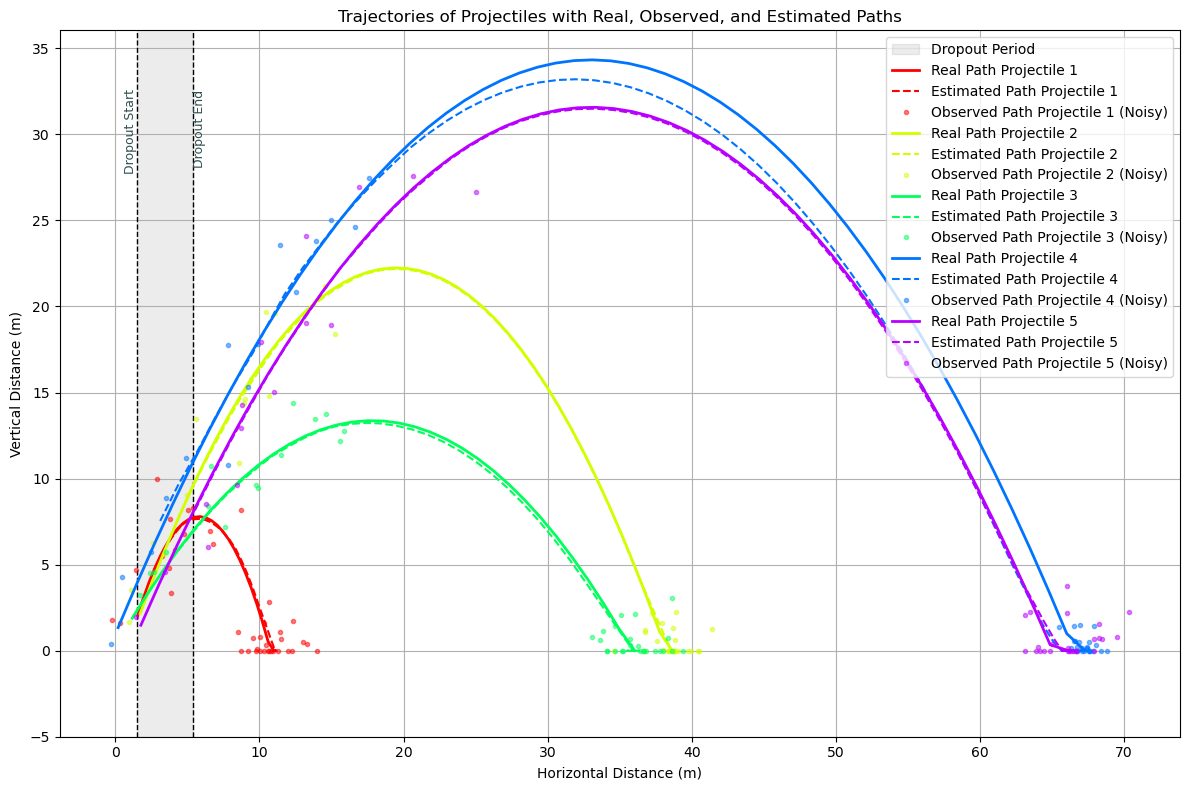

In [51]:
# --- Plotting ---

# Trajectories Plot
plt.figure(figsize=(12, 8))

# Highlight dropout period with a shaded area
dropout_start_time = dropout_start_index * delta_t
dropout_end_time = (dropout_start_index + dropout_duration_steps) * delta_t
plt.axvspan(dropout_start_time, dropout_end_time, color='grey', alpha=0.15, label='Dropout Period')

# Add vertical lines at the start and end of the dropout period for clearer marking
plt.axvline(dropout_start_time, color='black', linestyle='--', linewidth=1)
plt.axvline(dropout_end_time, color='black', linestyle='--', linewidth=1)

# Add text labels for dropout start and end for clear identification
text_y_pos = max_y_val * 0.95
plt.text(dropout_start_time, text_y_pos, 'Dropout Start', rotation=90, va='top', ha='right', color='darkslategray', fontsize=9)
plt.text(dropout_end_time, text_y_pos, 'Dropout End', rotation=90, va='top', ha='left', color='darkslategray', fontsize=9)

# Get a colormap object
colors_map = plt.colormaps.get_cmap('hsv')

for j in range(num_projectiles):
    # Normalize 'j' to a value between 0 and 1 for the colormap
    # This spreads the colors evenly across the colormap's range
    color_for_projectile = colors_map(j / num_projectiles)

    # Real positions (the true path that stops)
    plt.plot(all_x_real[j], all_y_real[j], label=f'Real Path Projectile {j+1}', color=color_for_projectile, linewidth=2)

    # Estimated positions (from the particle filter)
    plt.plot(all_estimates[j][:, 0], all_estimates[j][:, 1], '--', label=f'Estimated Path Projectile {j+1}', color=color_for_projectile, markersize=4, markeredgecolor='black')

    # Plot the observed data
    plt.plot(all_x_plot_observed[j], all_y_plot_observed[j], 'o', label=f'Observed Path Projectile {j+1} (Noisy)', color=color_for_projectile, alpha=0.5, markersize=3)
    
    
plt.title('Trajectories of Projectiles with Real, Observed, and Estimated Paths')
plt.xlabel('Horizontal Distance (m)')
plt.ylabel('Vertical Distance (m)')
plt.ylim(bottom=-5) # Ensure y-axis starts at 0.0
 # Dynamic x-axis, allowing negative for initial_x
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

### Compare Real and Estimated Velocities over Distance for Both Projectiles

<Figure size 1200x800 with 0 Axes>

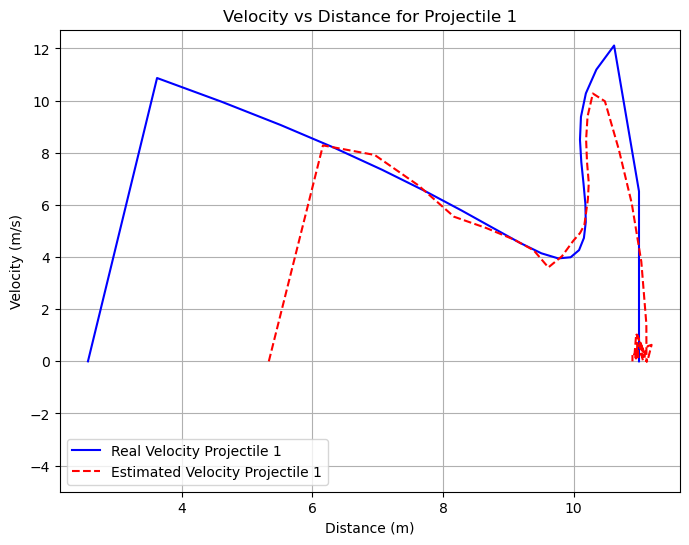

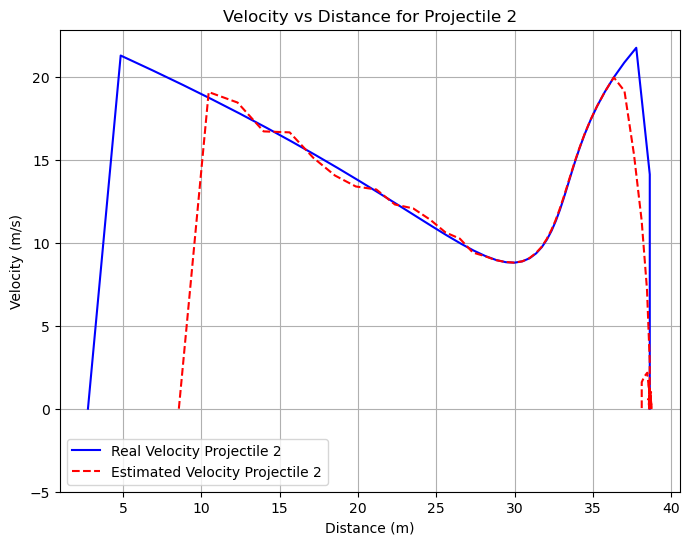

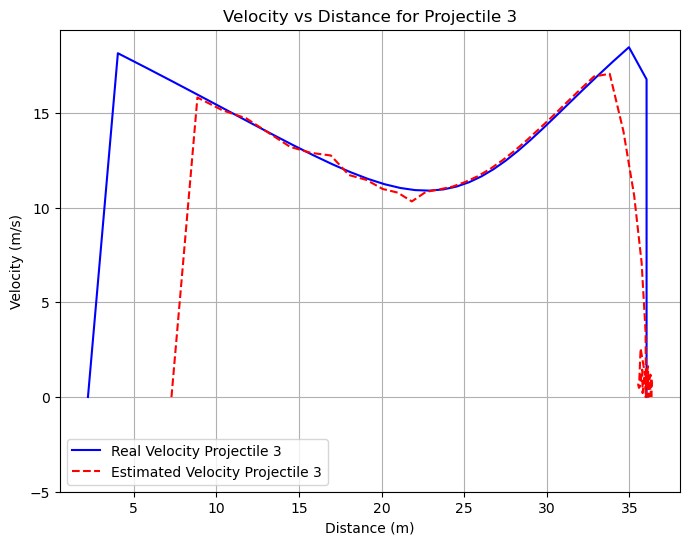

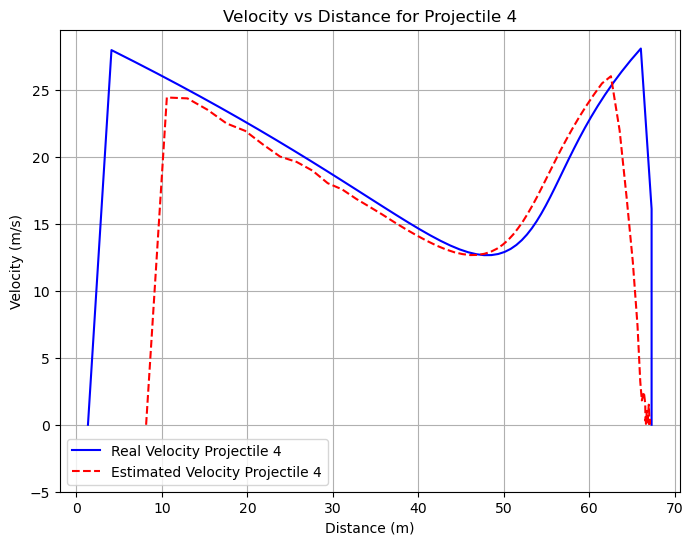

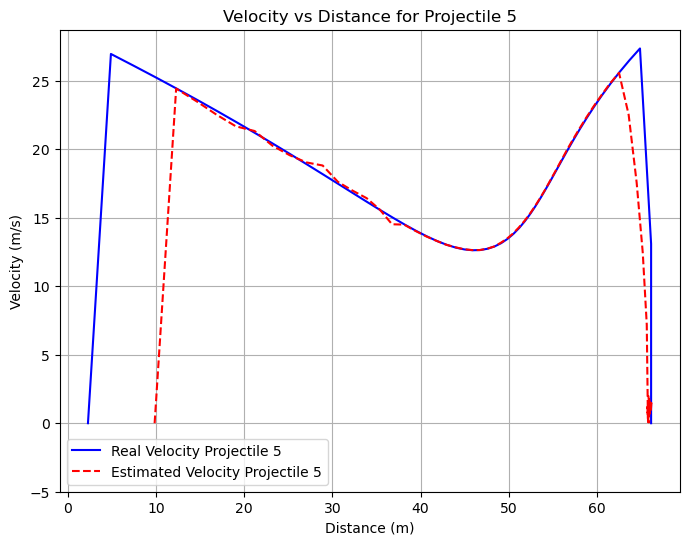

In [52]:
# --- Plotting ---

# Trajectories Plot
plt.figure(figsize=(12, 8))

# Velocity Plots
for j in range(num_projectiles):
    plt.figure(figsize=(8, 6))
    plt.plot(all_d_real[j], all_v_real[j], label=f'Real Velocity Projectile {j+1}', color='blue')
    plt.plot(all_d_estimated[j], all_v_estimated[j], label=f'Estimated Velocity Projectile {j+1}', linestyle='--', color='red')
    plt.title(f'Velocity vs Distance for Projectile {j+1}')
    plt.xlabel('Distance (m)')
    plt.ylabel('Velocity (m/s)')
    plt.ylim(bottom=-5) # Speed cannot be negative
    plt.grid()
    plt.legend()
    plt.show()